# Manipulating audio annotations

This notebook demonstrates how to use the `annotations` module of OpenSoundscape to

- load annotations from Raven files

- create a set of one-hot labels corresponding to fixed-length audio clips

- split a set of labeled audio files into clips and create labels dataframe for all clips

The audio recordings used in thise notebook were recorded by Andrew Spencer and are available under a Creative Commons License ([CC BY-NC-ND 2.5](https://creativecommons.org/licenses/by-nc-nd/2.5/)) from xeno-canto.org. Annotations were performed in Raven Pro software by our team.

In [1]:
from opensoundscape.audio import Audio
from opensoundscape.spectrogram import Spectrogram
from opensoundscape.annotations import BoxedAnnotations

import numpy as np
import pandas as pd
from glob import glob

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for big visuals
%config InlineBackend.figure_format = 'retina'

### download example files
Run the code below to download a set of example audio and raven annotations files for this tutorial. 

In [2]:
import subprocess
subprocess.run(['curl','https://pitt.box.com/shared/static/nzdzwwmyr3tkr6ig6sltw4b7jg3ptfe4.gz','-L', '-o','gwwa_audio_and_raven_annotations.tar.gz']) # Download the data
subprocess.run(["tar","-xzf", "gwwa_audio_and_raven_annotations.tar.gz"]) # Unzip the downloaded tar.gz file
subprocess.run(["rm", "gwwa_audio_and_raven_annotations.tar.gz"]) # Remove the file after its contents are unzipped

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100     7    0     7    0     0      6      0 --:--:--  0:00:01 --:--:--     6
100 5432k  100 5432k    0     0  2467k      0  0:00:02  0:00:02 --:--:-- 4984k


CompletedProcess(args=['rm', 'gwwa_audio_and_raven_annotations.tar.gz'], returncode=0)

## Load a single Raven annotation table from a txt file

We can use the BoxedAnnotation class's `from_raven_file` method to load a Raven txt file into OpenSoundscape. This table contains the frequency and time limits of rectangular "boxes" representing each annotation that was created in Raven. 

Note that we need to specify the name of the column containing annotations, since it can be named anything in Raven. The column will be renamed to "annotation". 

This table looks a lot like what you would see in the Raven interface.

In [3]:
# specify an audio file and corresponding raven annotation file
audio_file = './gwwa_audio_and_raven_annotations/GWWA_XC/13738.wav'
annotation_file = './gwwa_audio_and_raven_annotations/GWWA_XC_AnnoTables/13738.Table.1.selections.txt'

let's look at a spectrogram of the audio file to see what we're working with

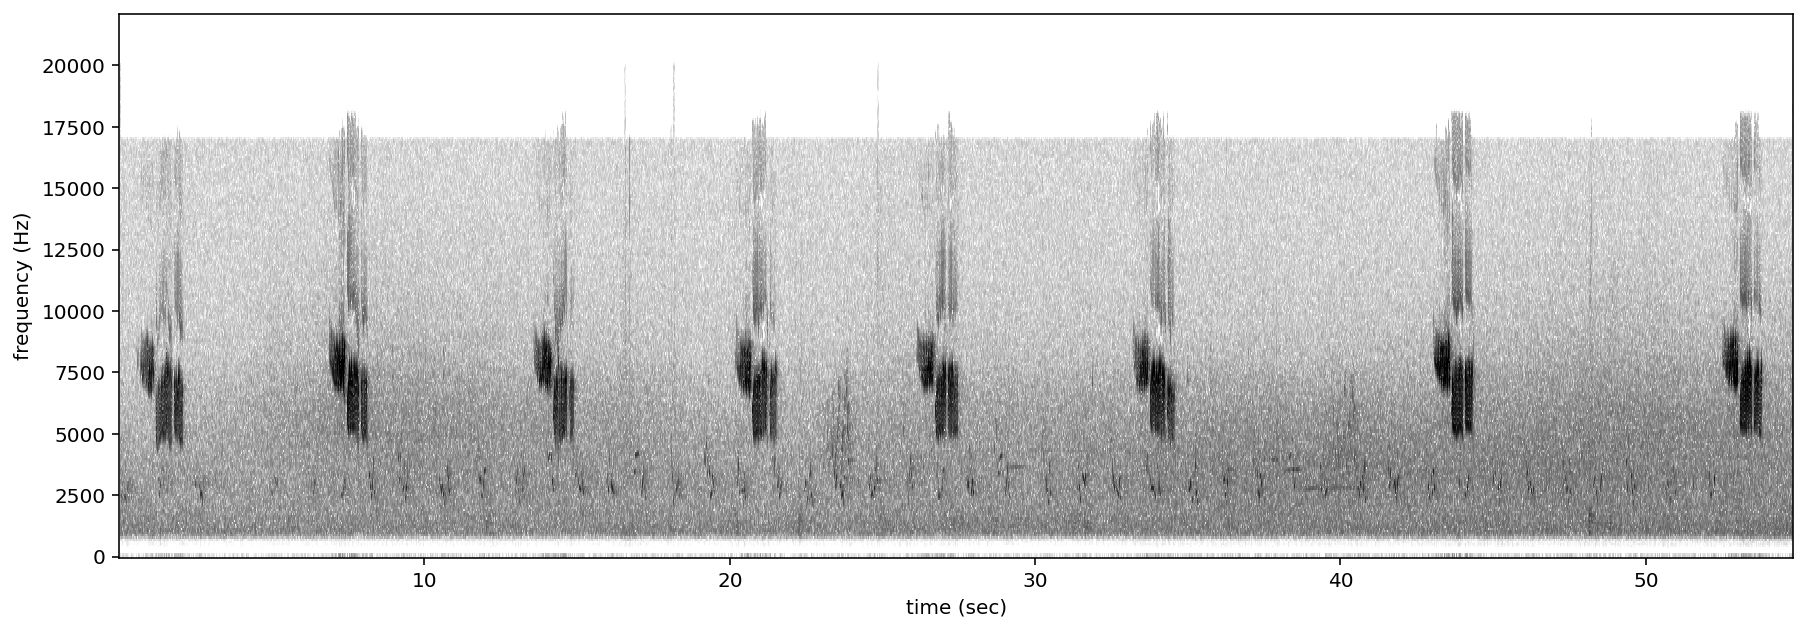

In [4]:
Spectrogram.from_audio(Audio.from_file(audio_file)).plot()

now, let's load the annotations from the Raven annotation file

In [5]:
#create an object from Raven file
annotations = BoxedAnnotations.from_raven_file(annotation_file,annotation_column='Species')

#inspect the object's .df attribute, which contains the table of annotations
annotations.df.head()

,Selection,View,Channel,start_time,end_time,low_f,high_f,annotation,Notes
0,1,Spectrogram 1,1,0.459636,2.298182,4029.8,17006.4,GWWA_song,NaN
1,2,Spectrogram 1,1,6.705283,8.246417,4156.6,17031.7,GWWA_song,NaN
2,3,Spectrogram 1,1,13.464641,15.005775,3903.1,17082.4,?,NaN
3,4,Spectrogram 1,1,20.128208,21.601748,4055.2,16930.3,GWWA_song,NaN
4,5,Spectrogram 1,1,26.047590,27.521131,4207.2,17057.1,GWWA_song,NaN


we could instead choose to load it with only the necessary columns, plus the "Notes" column

In [6]:
annotations = BoxedAnnotations.from_raven_file(annotation_file,annotation_column='Species',keep_extra_columns=['Notes'])
annotations.df.head()

,start_time,end_time,low_f,high_f,annotation,Notes
0,0.459636,2.298182,4029.8,17006.4,GWWA_song,NaN
1,6.705283,8.246417,4156.6,17031.7,GWWA_song,NaN
2,13.464641,15.005775,3903.1,17082.4,?,NaN
3,20.128208,21.601748,4055.2,16930.3,GWWA_song,NaN
4,26.047590,27.521131,4207.2,17057.1,GWWA_song,NaN


## Convert or correct annotations
We can provide a DataFrame (e.g., from a .csv file) or a dictionary to convert original values to new values. 

Let's load up a little csv file that specifies a set of conversions we'd like to make. The csv file should have two columns, but it doesn't matter what they are called. If you create a table in Microsoft Excel, you can export it to a .csv file to use it as your conversion table. 

In [7]:
conversion_table = pd.read_csv('./gwwa_audio_and_raven_annotations/conversion_table.csv')
conversion_table

,original,new
0,gwwa_song,gwwa


alternatively, we could simply write a Python dictionary for the conversion table. For instance:

In [8]:
conversion_table = {
    "GWWA_song":"GWWA",
    "?":np.nan
}

now, we can apply the conversions in the table to our annotations.

This will create a new BoxedAnnotations object rather than modifying the original object ("out of place operation")

In [9]:
annotations_corrected = annotations.convert_labels(conversion_table)
annotations_corrected.df

,start_time,end_time,low_f,high_f,annotation,Notes
0,0.459636,2.298182,4029.8,17006.4,GWWA,NaN
1,6.705283,8.246417,4156.6,17031.7,GWWA,NaN
2,13.464641,15.005775,3903.1,17082.4,NaN,NaN
3,20.128208,21.601748,4055.2,16930.3,GWWA,NaN
4,26.047590,27.521131,4207.2,17057.1,GWWA,NaN
5,33.121946,34.663079,4207.2,17082.4,GWWA,NaN
6,42.967925,44.427946,4181.9,17057.1,GWWA,NaN
7,52.417508,53.891048,4232.6,16930.3,GWWA,NaN


### View a subset of annotations
Specify a list of classes to include in the subset

for example, we can subset to only annotations marked as '?'

In [10]:
classes_to_keep = ['?']
annotations_only_unsure = annotations.subset(classes_to_keep)
annotations_only_unsure.df

,start_time,end_time,low_f,high_f,annotation,Notes
2,13.464641,15.005775,3903.1,17082.4,?,NaN


### saving annotations to Raven-compatible file
We can always save our BoxedAnnotations object to a Raven-compatible txt file, which can be opened in Raven along with an audio file just like the files Raven creates itself. You must specify a path for the save file that ends with `.txt`. 

In [11]:
annotations_only_unsure.to_raven_file('./gwwa_audio_and_raven_annotations/13738_unsure.txt')

## Splitting annotations along with audio
Often, we want to train or validate models on short audio segments (e.g., 5 seconds) rather than on long files (e.g., 2 hours). 

We can accomplish this in three ways: 

(1) Split the annotations (`.one_hot_labels_like()`) using the DataFrame returned by `Audio.split()` (this dataframe includes the start and end times of each clip)

(2) Create a dataframe of start and end times, and split the audio accordingly 

(3) directly split the labels with `.one_hot_clip_labels()`, using splitting parameters that match Audio.split()

All three methods are demonstrated below.

### 1. Split Audio object, then split annotations to match

After splitting audio with audio.split(), we'll use BoxedAnnotation's `one_hot_labels_like()` function to extract the labels for each audio clip. This function requires that we specify the minimum overlap of the label (in seconds) with the clip for the clip to be labeled positive. We also specify the list of classes for one-hot labels (if we give classes=None, it will make a column for every unique label in the annotations).

In [12]:
# load the Audio and Annotations
audio = Audio.from_file(audio_file)
annotations = BoxedAnnotations.from_raven_file(annotation_file,annotation_column='Species')

# split the audio into 5 second clips with no overlap (we use _ because we don't really need to save the audio clip objects for this demo)
_, clip_df = audio.split(clip_duration=5.0, clip_overlap=0.0)

labels_df = annotations.one_hot_labels_like(clip_df,min_label_overlap=0.25,classes=['GWWA_song'])

#the returned dataframe of one-hot labels (0/1 for each class and each clip) has rows corresponding to each audio clip
labels_df.head()

,,GWWA_song
start_time,end_time,
0.0,5.0,1.0
5.0,10.0,1.0
10.0,15.0,0.0
15.0,20.0,0.0
20.0,25.0,1.0


### 2. Split annotations into labels (without audio splitting)

The function in the previous example, `one_hot_labels_like()`, splits the labels according to start and end times from a DataFrame. But how would we get that DataFrame if we aren't actually splitting Audio files? 

We can create the dataframe with a helper function that takes the same splitting parameters as Audio.split(). Notice that we need to specify one additional parameter: the entire duration to be split (`full_duration`).


In [13]:
# generate clip start/end time DataFrame
from opensoundscape.helpers import generate_clip_times_df
clip_df = generate_clip_times_df(full_duration=60,clip_duration=5.0, clip_overlap=0.0)

#we can use the clip_df to split the Annotations in the same way as before
labels_df = annotations.one_hot_labels_like(clip_df,min_label_overlap=0.25,classes=['GWWA_song'])

#the returned dataframe of one-hot labels (0/1 for each class and each clip) has rows corresponding to each audio clip
labels_df.head()

,,GWWA_song
start_time,end_time,
0.0,5.0,1.0
5.0,10.0,1.0
10.0,15.0,0.0
15.0,20.0,0.0
20.0,25.0,1.0


### 3. Split annotations directly using splitting parameters

Though we recommend using one of the above methods, you can also split annotations by directly calling `one_hot_clip_labels()`. This method combines the two steps in the examples above (creating a clip df and splitting the annotations), and requires that you specify the parameters for both of those steps. 

Here's an example that produces equivalent results to the previous examples:

In [14]:
labels_df = annotations.one_hot_clip_labels(
    full_duration=60,
    clip_duration=5,
    clip_overlap=0,
    classes=['GWWA_song'],
    min_label_overlap=0.25,    
)
labels_df.head()

,,GWWA_song
start_time,end_time,
0,5,1.0
5,10,1.0
10,15,0.0
15,20,0.0
20,25,1.0


## Create audio clips and one-hot labels from many audio and annotation files

Let's get to the useful part - you have tons of audio files (with corresponding Raven files) and you need to create one-hot labels for 5 second clips on all of them. Can't we just give you the code you need to get this done?! 

Sure :)

but be warned, matching up the correct raven and audio files might require some finagling

### find all the Raven and audio files, and see if they match up one-to-one
caveat: you'll need to be careful about matching up the correct Raven files and audio files. In this example, we'll assume our Raven files have exactly the same name (ignoring the extensions like ".Table.1.selections.txt") as our audio files, *and* that these file names *are unique (!)* - that is, no two audio files have the same name. 

In [15]:
# specify folder containing Raven annotations
raven_files_dir = "./gwwa_audio_and_raven_annotations/GWWA_XC_AnnoTables/"

# find all .txt files (we'll naively assume all txt files are Raven files!)
raven_files = glob(f"{raven_files_dir}/*.txt")
print(f"found {len(raven_files)} annotation files")

#specify folder containing audio files
audio_files_dir = "./gwwa_audio_and_raven_annotations/GWWA_XC/"

# find all audio files (we'll assume they are .wav, .WAV, or .mp3)
audio_files = glob(f"{audio_files_dir}/*.wav")+glob(f"{audio_files_dir}/*.WAV")+glob(f"{audio_files_dir}/*.mp3")
print(f"found {len(audio_files)} audio files")

# pair up the raven and audio files based on the audio file name
from pathlib import Path
audio_df = pd.DataFrame({'audio_file':audio_files})
audio_df.index = [Path(f).stem for f in audio_files]

#check that there aren't duplicate audio file names
print('\n audio files with duplicate names:')
audio_df[audio_df.index.duplicated(keep=False)]

found 3 annotation files
found 3 audio files

 audio files with duplicate names:


,audio_file


In [16]:
raven_df = pd.DataFrame({'raven_file':raven_files})
raven_df.index = [Path(f).stem.split('.Table')[0] for f in raven_files]

#check that there aren't duplicate audio file names
print('\n raven files with duplicate names:')
raven_df[raven_df.index.duplicated(keep=False)]


 raven files with duplicate names:


,raven_file
13738,./gwwa_audio_and_raven_annotations/GWWA_XC_Ann...
13738,./gwwa_audio_and_raven_annotations/GWWA_XC_Ann...


Once we've resolved any issues with duplicate names, we can match up raven and audio files.

In [17]:
#remove the second selection table for file 13738.wav
raven_df=raven_df[raven_df.raven_file.apply(lambda x: "selections2" not in x)]

In [18]:
paired_df = audio_df.join(raven_df,how='outer')

check if any audio files don't have annotation files

In [19]:
print(f"audio files without raven file: {len(paired_df[paired_df.raven_file.apply(lambda x:x!=x)])}")
paired_df[paired_df.raven_file.apply(lambda x:x!=x)]

audio files without raven file: 2


,audio_file,raven_file
135601,./gwwa_audio_and_raven_annotations/GWWA_XC/135...,NaN
13742,./gwwa_audio_and_raven_annotations/GWWA_XC/137...,NaN


check if any raven files don't have audio files

In [20]:
#look at unmatched raven files
print(f"raven files without audio file: {len(paired_df[paired_df.audio_file.apply(lambda x:x!=x)])}")

paired_df[paired_df.audio_file.apply(lambda x:x!=x)]

raven files without audio file: 1


,audio_file,raven_file
16989,NaN,./gwwa_audio_and_raven_annotations/GWWA_XC_Ann...


In this example, let's discard any unpaired raven or audio files

In [21]:
paired_df = paired_df.dropna()

In [22]:
paired_df

,audio_file,raven_file
13738,./gwwa_audio_and_raven_annotations/GWWA_XC/137...,./gwwa_audio_and_raven_annotations/GWWA_XC_Ann...


### split and save the audio and annotations
Now we have a set of paired up raven and audio files. 

Let's split each of the audio files and create the corresponding labels. 

We'll want to keep the names of the audio clips that we create using Audio.split_and_save() so that we can correspond them with one-hot clip labels.

Note: it will be confusing and annoying if your Raven files use different names for the annotation column. Ideally, all of your raven files should have the same column name for the annotations. 

In [23]:
%%bash 
mkdir -p ./temp_clips

In [24]:
#choose settings for audio splitting
clip_duration = 3
clip_overlap = 0
final_clip = None
clip_dir = './temp_clips'

#choose settings for annotation splitting
classes = None#['GWWA_song','GWWA_dzit'] #list of all classes, or None
min_label_overlap = 0.1


#store the label dataframes from each audio file so that we can aggregate them later
#Note: if you have a huge number (millions) of annotations, this might get very large. 
#an alternative would be to save the individual dataframes to files, then concatenate them later. 
all_labels = []

cnt = 0

for i, row in paired_df.iterrows():
    #load the audio into an Audio object
    audio = Audio.from_file(row['audio_file'])
    
    #in this example, only the first 60 seconds of audio is annotated
    #so trim the audio to 60 seconds max
    audio = audio.trim(0,60)
    
    #split the audio and save the clips
    clip_df = audio.split_and_save(
        clip_dir,
        prefix=row.name,
        clip_duration=clip_duration,
        clip_overlap=clip_overlap,
        final_clip=final_clip,
        dry_run=False
    )
    
    #load the annotation file into a BoxedAnnotation object
    annotations = BoxedAnnotations.from_raven_file(row['raven_file'],annotation_column='Species')
    
    #since we trimmed the audio, we'll also trim the annotations for consistency
    annotations = annotations.trim(0,60)
    
    #split the annotations to match the audio
    #we choose to keep_index=True so that we retain the audio clip's path in the final label dataframe
    labels = annotations.one_hot_labels_like(clip_df,classes=classes,min_label_overlap=min_label_overlap,keep_index=True)
    
    #since we have saved short audio clips, we can discard the start_time and end_time indices
    labels = labels.reset_index(level=[1,2],drop=True)
    all_labels.append(labels)
    
    cnt+=1
    if cnt>2:
        break

#make one big dataframe with all of the labels. We could use this for training, for instance. 
all_labels = pd.concat(all_labels)

In [25]:
all_labels

,?,GWWA_song
file,,
./temp_clips/13738_0.0s_3.0s.wav,0.0,1.0
./temp_clips/13738_3.0s_6.0s.wav,0.0,0.0
./temp_clips/13738_6.0s_9.0s.wav,0.0,1.0
./temp_clips/13738_9.0s_12.0s.wav,0.0,0.0
./temp_clips/13738_12.0s_15.0s.wav,1.0,0.0
./temp_clips/13738_15.0s_18.0s.wav,0.0,0.0
./temp_clips/13738_18.0s_21.0s.wav,0.0,1.0
./temp_clips/13738_21.0s_24.0s.wav,0.0,1.0
./temp_clips/13738_24.0s_27.0s.wav,0.0,1.0


### sanity check: look at spectrograms of clips labeled 0 and 1

In [26]:
# ignore the "?" annotations for this visualization
all_labels = all_labels[all_labels["?"]==0]

spectrograms of 3 random positive clips (label=1)


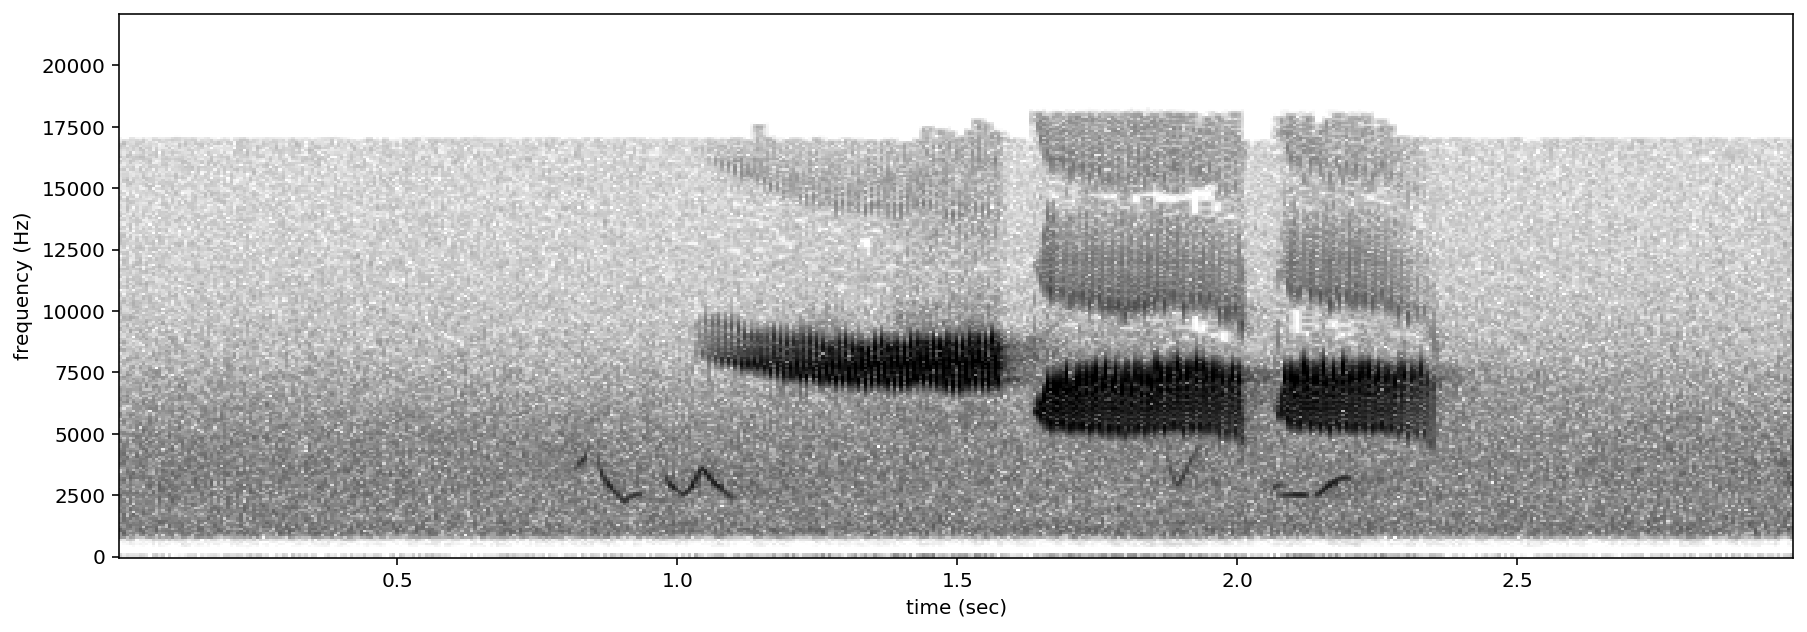

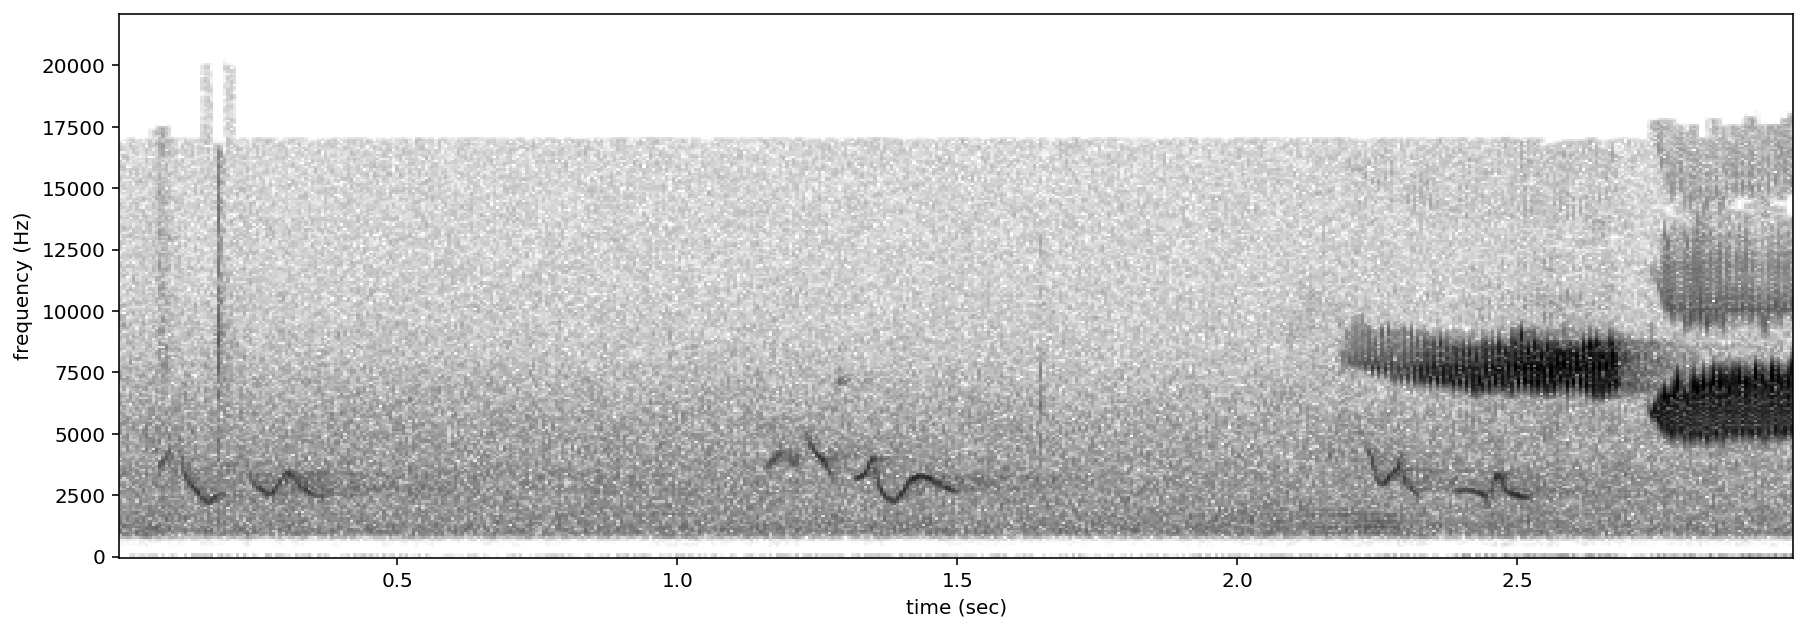

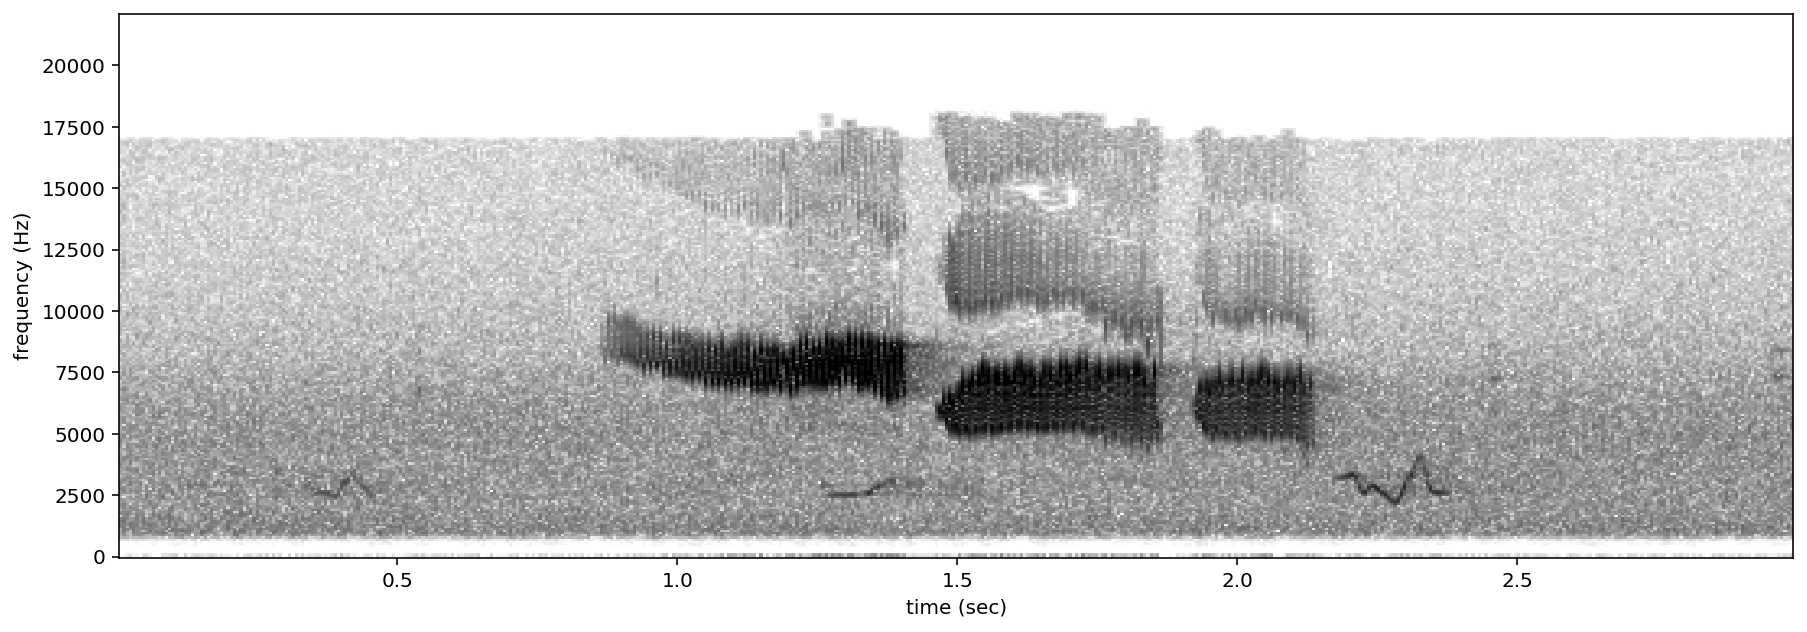

spectrogram of 3 random negative clips (label=0)


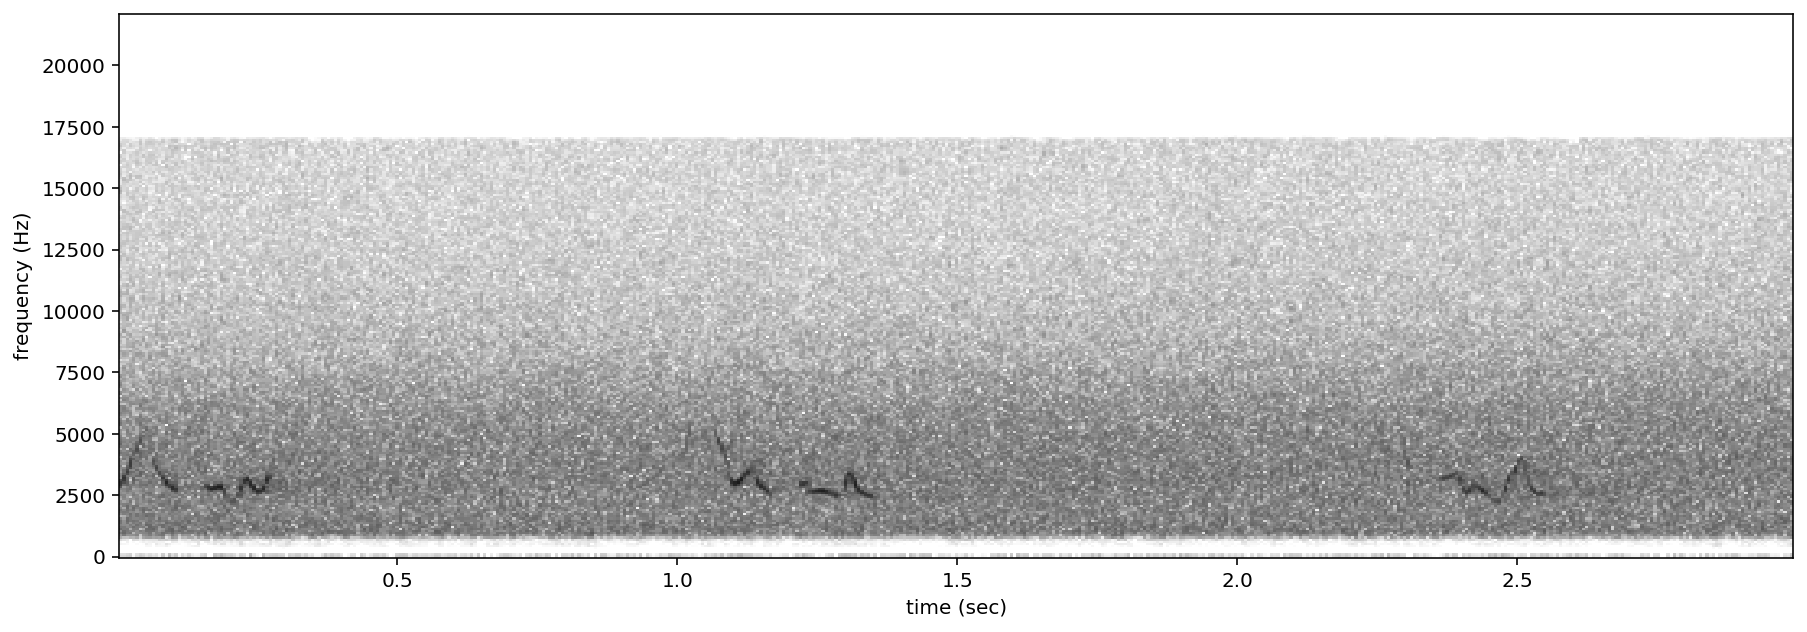

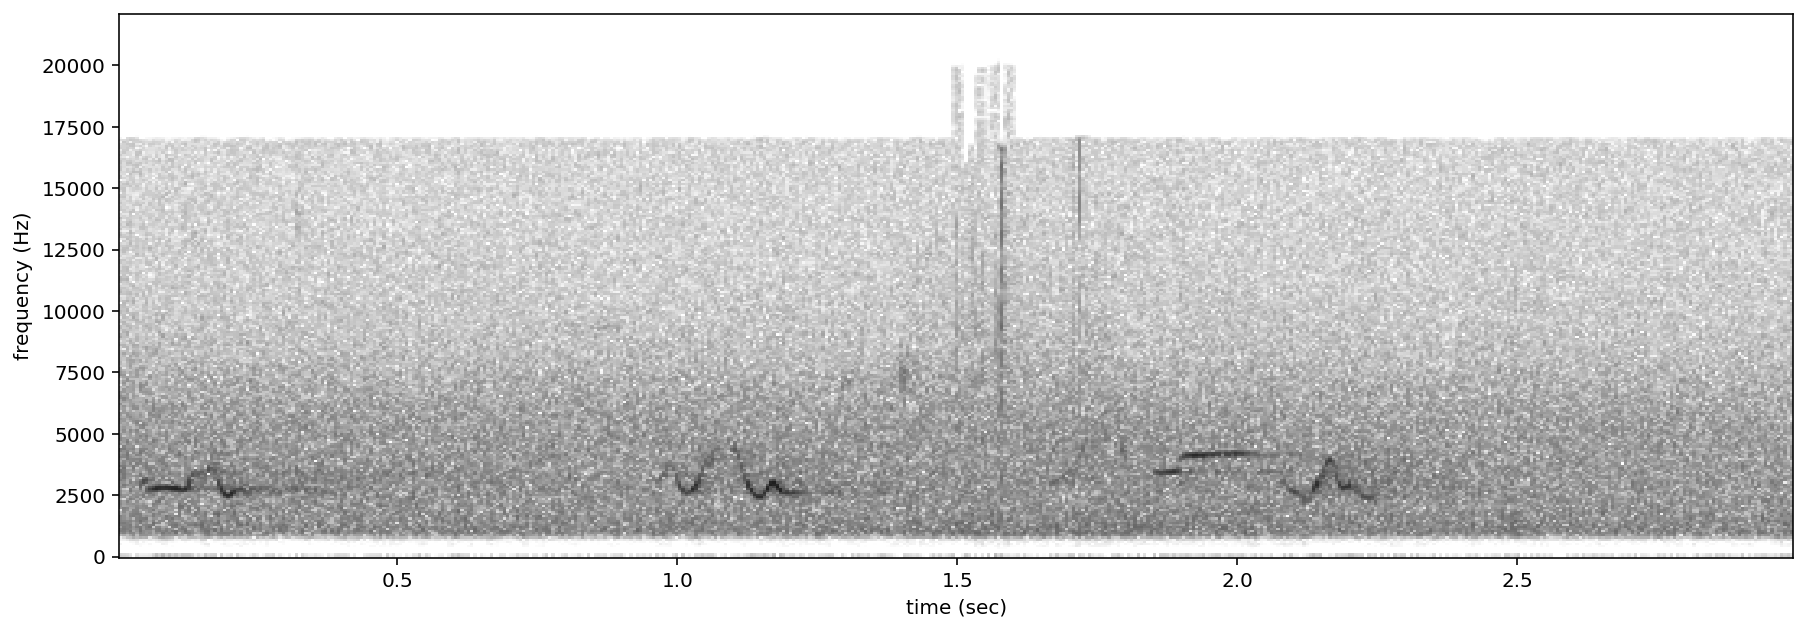

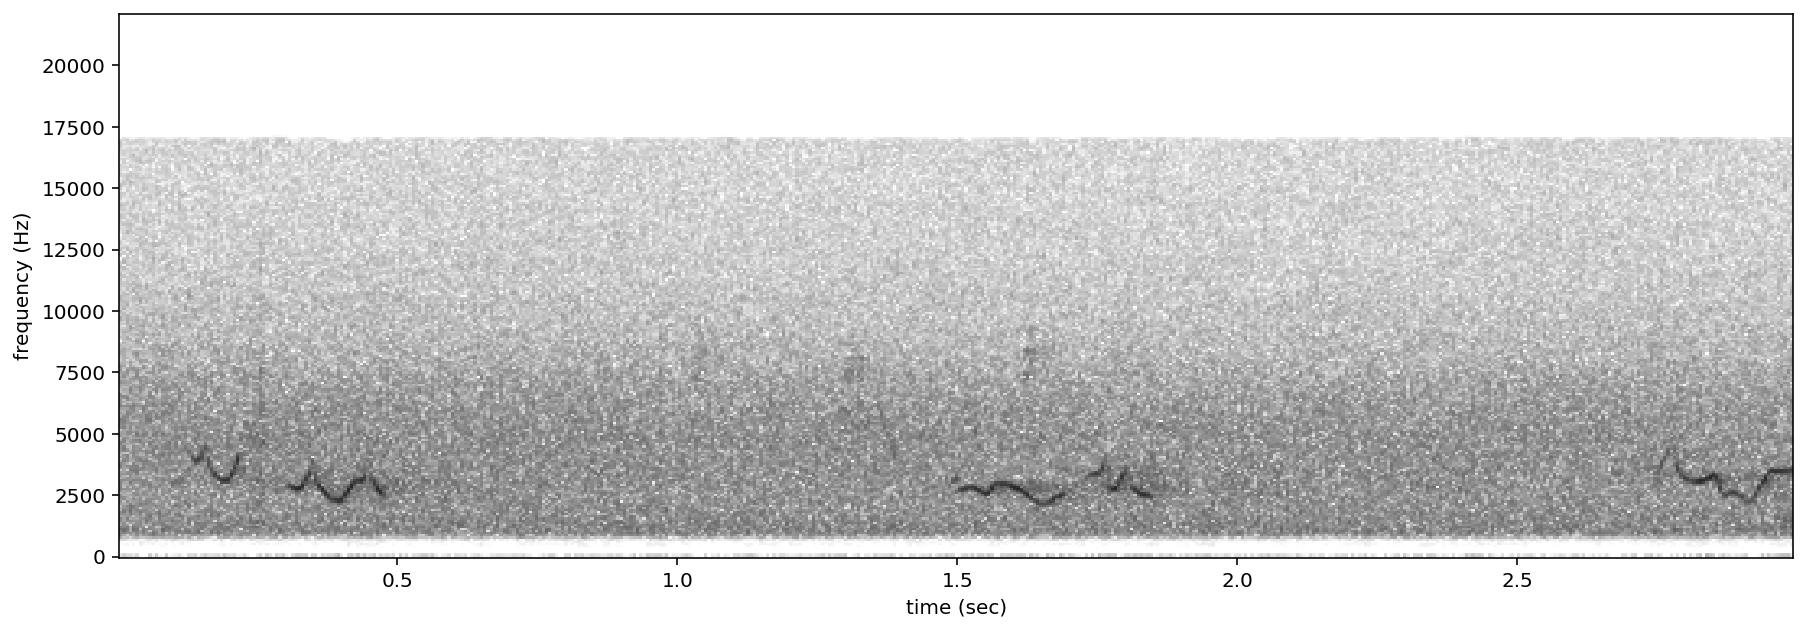

In [27]:
# plot spectrograms for 3 random positive clips
positives = all_labels[all_labels['GWWA_song']==1].sample(3,random_state=0)
print("spectrograms of 3 random positive clips (label=1)")
for positive_clip in positives.index.values:
    Spectrogram.from_audio(Audio.from_file(positive_clip)).plot()

# plot spectrograms for 5 random negative clips
negatives = all_labels[all_labels['GWWA_song']==0].sample(3,random_state=0)
print("spectrogram of 3 random negative clips (label=0)")
for negative_clip in negatives.index.values:
    Spectrogram.from_audio(Audio.from_file(negative_clip)).plot()


clean up: remove temp_clips directory

In [28]:
import shutil
shutil.rmtree('./gwwa_audio_and_raven_annotations')
shutil.rmtree('./temp_clips')